# $D^0 \to K^0_Sπ^+π^-$ with TFA2

We will fit 

$$
D^0 \to K^0_S \pi^+\pi^-
$$

decays generated with the following intermediate resonances:
- $D^0 \to K^0_S \rho(770)$
- $D^0 \to K^{*-}\pi^+$

Import modules

In [1]:
# Import AmpliTF modules
import amplitf.interface as atfi
import amplitf.kinematics as atfk
import amplitf.dynamics as atfd
import amplitf.likelihood as atfl
from amplitf.phasespace.dalitz_phasespace import DalitzPhaseSpace

# Import TFA modules
import tfa.toymc as tft
import tfa.plotting as tfp
import tfa.optimisation as tfo

2024-07-05 15:33:50.387045: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-05 15:33:50.399440: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-05 15:33:50.416938: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-05 15:33:50.416958: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-05 15:33:50.427630: I tensorflow/core/platform/cpu_feature_gua

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Set the number of events to generate and the number of normalisation point to calculate the integral of the likelihood

In [2]:
ntoys = 100000  # Number of points to generate
nnorm = 1000000  # Number of normalisation points

Now define some constants

In [3]:
# Masses of final state particles
from particle.particle import literals as lp
# Dalitz Particles
mkz = atfi.const(lp.K_S_0.mass/1000)
mpi = atfi.const(lp.pi_plus.mass/1000)
md = atfi.const(lp.D_0.mass/1000)

# Resonances
mkst = atfi.const(lp.Kst_892_0.mass/1000)
wkst = atfi.const(lp.Kst_892_0.width/1000)
mrho = atfi.const(lp.rho_770_0.mass/1000)
wrho = atfi.const(lp.rho_770_0.width/1000)

# Blatt-Weisskopf radii for Breit-Wigner lineshape
rd = atfi.const(5.0)
rr = atfi.const(1.5)

2024-07-05 15:33:52.152206: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 888 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:b1:00.0, compute capability: 8.0


and a class to deal with three-body Dalitz phase-space

In [4]:
phsp = DalitzPhaseSpace(mpi, mkz, mpi, md)

## Model
Below there is a function to define the model, allowing to switch on and off specific components.

In [5]:
def model(x):

    m2ab = phsp.m2ab(x)
    m2bc = phsp.m2bc(x)
    m2ac = phsp.m2ac(x)

    hel_ab = atfd.helicity_amplitude(phsp.cos_helicity_ab(x), 1)
    hel_bc = atfd.helicity_amplitude(phsp.cos_helicity_bc(x), 1)
    hel_ac = atfd.helicity_amplitude(phsp.cos_helicity_ac(x), 1)

    bw1 = atfd.breit_wigner_lineshape(m2ab, mkst, wkst, mpi, mkz, mpi, md, rd, rr, 1, 1)
    bw2 = atfd.breit_wigner_lineshape(m2bc, mkst, wkst, mpi, mkz, mpi, md, rd, rr, 1, 1)
    bw3 = atfd.breit_wigner_lineshape(m2ac, mrho, wrho, mpi, mpi, mkz, md, rd, rr, 1, 1)

    def _model(a1r, a1i, a2r, a2i, a3r, a3i, switches=4 * [1]):

        a1 = atfi.complex(a1r, a1i)
        a2 = atfi.complex(a2r, a2i)
        a3 = atfi.complex(a3r, a3i)

        ampl = atfi.cast_complex(atfi.ones(m2ab)) * atfi.complex(
            atfi.const(0.0), atfi.const(0.0)
        )

        if switches[0]:
            ampl += a1 * bw1 * hel_ab
        if switches[1]:
            ampl += a2 * bw2 * hel_bc
        if switches[2]:
            ampl += a3 * bw3 * hel_ac
        if switches[3]:
            ampl += atfi.cast_complex(atfi.ones(m2ab)) * atfi.complex(
                atfi.const(5.0), atfi.const(0.0)
            )

        return atfd.density(ampl)

    return _model

## Toy MC Model
The model of the toy MC has all the components on by default. By means of the `switches` flag, some of them can be turned off to see the effects on the fit.

In [6]:
def toymc_model(x, switches=4 * [1]):
    return model(x)(
        switches=switches,
        a1r=atfi.const(1.0),
        a1i=atfi.const(0.0),
        a2r=atfi.const(0.5),
        a2i=atfi.const(0.0),
        a3r=atfi.const(2.0),
        a3i=atfi.const(0.0),
    )

## Likelihood

The Negative Log Likelihood

In [7]:
# TF graph for unbinned negalite log likelihood (the quantity to be minimised)
def nll(data, norm):
    data_model = model(data)
    norm_model = model(norm)

    @atfi.function
    def _nll(pars):
        return atfl.unbinned_nll(data_model(**pars), atfl.integral(norm_model(**pars)))

    return _nll

## Samples

The samples to fit

In [8]:
toy_sample = tft.run_toymc(
    toymc_model, phsp, ntoys, maximum=1.0e-20, chunk=1000000, components=False
)

print(toy_sample)

  Updating maximum: 1e-20 -> 963.4049544317415. Starting over.
  Chunk 1, size=28030, total length=28030
  Chunk 2, size=28225, total length=56255
  Chunk 3, size=27987, total length=84242
  Chunk 4, size=28136, total length=112378
tf.Tensor(
[[2.12286026 0.90960834]
 [0.4912045  2.85042055]
 [0.81002062 1.13832583]
 ...
 [0.65659309 2.48425068]
 [0.84228717 1.27644687]
 [2.55698713 0.53414808]], shape=(100000, 2), dtype=float64)


and to calculate the integrals

In [9]:
norm_sample = phsp.uniform_sample(nnorm)

print(norm_sample)

tf.Tensor(
[[0.7689357  1.34581232]
 [0.50385496 2.03323931]
 [2.65938743 0.8937069 ]
 ...
 [2.12092856 0.67400523]
 [1.71140071 1.66500784]
 [2.12768811 0.66457935]], shape=(474833, 2), dtype=float64)


Beware that only approximately 1/2 of the events have been generated in the normalisation sample.

## Fit

We are now ready to run the fit. We define first the fit parameters:

In [10]:
pars = [
    tfo.FitParameter("a1r", 1.0, -10.0, 10.0),
    tfo.FitParameter("a1i", 0.0, -10.0, 10.0),
    tfo.FitParameter("a2r", 0.5, -10.0, 10.0),
    tfo.FitParameter("a2i", 0.0, -10.0, 10.0),
    tfo.FitParameter("a3r", 2.0, -10.0, 10.0),
    tfo.FitParameter("a3i", 0.0, -10.0, 10.0),
]

and run Minuit

In [11]:
# Run MINUIT minimisation of the neg. log likelihood
result = tfo.run_minuit(nll(toy_sample, norm_sample), pars)
print(result)
cov = result['covariance']

print(f"{result['time']/result['func_calls']} sec per function call")

fitted_pars = {p: atfi.const(v[0]) for p, v in result["params"].items()}

10 -55330.65457516814 [ 1.00000000e+00 -1.62431371e-06  5.00000000e-01  0.00000000e+00
  2.00000000e+00  0.00000000e+00]
20 -55330.65417493334 [1.         0.         0.5        0.         1.99999906 0.        ]
30 -55333.43224515203 [ 0.99461904 -0.0122471   0.50413615 -0.00229154  1.99731033 -0.00601725]
40 -55333.490455536965 [ 0.9937261  -0.01278674  0.50303514 -0.00320916  1.99696035 -0.00725885]
50 -55333.49046154196 [ 0.99372138 -0.01278674  0.50303514 -0.00320899  1.99696035 -0.00725885]
60 -55333.490461820795 [ 0.99372138 -0.01278674  0.50303514 -0.00320916  1.99696035 -0.00725722]
70 -55333.49045837057 [ 0.99372138 -0.01278674  0.50303514 -0.00320916  1.99696975 -0.00725885]
80 -55333.49046144537 [ 0.99372138 -0.01278674  0.50303514 -0.00320883  1.99696035 -0.00725885]
90 -55333.49045574386 [ 0.9937261  -0.01278674  0.50303514 -0.00320916  1.99696035 -0.00725722]
100 -55333.49045851305 [ 0.99372138 -0.01278674  0.50303514 -0.00320916  1.99696975 -0.00725722]
┌─────────────────

Define a function with the fitted model to calculate fit fractions and projections

In [12]:
def fitted_model(x, switches=4 * [1]):
    return model(x)(**fitted_pars, switches=switches)

The fit fractions are calculated

In [13]:
ff = tfo.calculate_fit_fractions(fitted_model, norm_sample)
print(ff)

[0.2147672800759669, 0.055273778612024246, 0.39623584940321865, 0.4382993977825004]


## Plotting

For plotting the results we generate a sample according to the model and we overlay it to the data

In [14]:
fitted_sample = tft.run_toymc(
    fitted_model, phsp, nnorm, maximum=1.0e-20, chunk=1000000, components=True
)

  Updating maximum: 1e-20 -> 950.344480144272. Starting over.
  Chunk 1, size=28499, total length=28499
  Chunk 2, size=28483, total length=56982
  Chunk 3, size=28499, total length=85481
  Chunk 4, size=28558, total length=114039
  Chunk 5, size=28645, total length=142684
  Chunk 6, size=28531, total length=171215
  Chunk 7, size=28206, total length=199421
  Chunk 8, size=28404, total length=227825
  Chunk 9, size=28690, total length=256515
  Chunk 10, size=28798, total length=285313
  Chunk 11, size=28348, total length=313661
  Chunk 12, size=28451, total length=342112
  Chunk 13, size=28433, total length=370545
  Chunk 14, size=28268, total length=398813
  Chunk 15, size=28731, total length=427544
  Chunk 16, size=28485, total length=456029
  Chunk 17, size=28516, total length=484545
  Chunk 18, size=28507, total length=513052
  Chunk 19, size=28428, total length=541480
  Chunk 20, size=28388, total length=569868
  Chunk 21, size=28473, total length=598341
  Chunk 22, size=28580, to

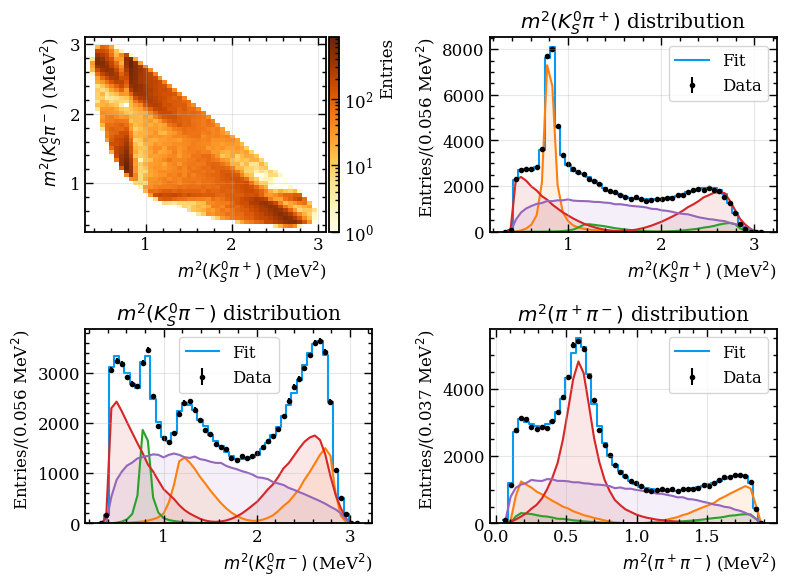

In [15]:
# Plot results
import matplotlib.pyplot as plt

tfp.set_lhcb_style(size=12, usetex=False)  # Adjust plotting style for LHCb papers
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))  # Single subplot on the figure

# Plot 1D histogram from the toy MC sample
tfp.plot_distr2d(
    toy_sample[:, 0],
    toy_sample[:, 1],
    bins=(50, 50),
    ranges=((0.3, 3.1), (0.3, 3.1)),
    fig=fig,
    ax=ax[0, 0],
    labels=(r"$m^2(K_S^0\pi^+)$", r"$m^2(K_S^0\pi^-)$"),
    units=("MeV$^2$", "MeV$^2$"),
    log=True,
)

tfp.plot_distr1d_comparison(
    toy_sample[:, 0],
    fitted_sample[:, 0],
    cweights=[fitted_sample[:, 2 + i] for i in range(4)],
    bins=50,
    range=(0.3, 3.1),
    ax=ax[0, 1],
    label=r"$m^2(K_S^0\pi^+)$",
    units="MeV$^2$",
)

tfp.plot_distr1d_comparison(
    toy_sample[:, 1],
    fitted_sample[:, 1],
    cweights=[fitted_sample[:, 2 + i] for i in range(4)],
    bins=50,
    range=(0.3, 3.1),
    ax=ax[1, 0],
    label=r"$m^2(K_S^0\pi^-)$",
    units="MeV$^2$",
)

tfp.plot_distr1d_comparison(
    phsp.m2ac(toy_sample),
    phsp.m2ac(fitted_sample),
    cweights=[fitted_sample[:, 2 + i] for i in range(4)],
    bins=50,
    range=(0.05, 1.9),
    ax=ax[1, 1],
    label=r"$m^2(\pi^+\pi^-)$",
    units="MeV$^2$",
)

# Show the plot
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)

In [16]:
samp = phsp.filter(phsp.unfiltered_sample(1000))

In [18]:
model(samp)

<function __main__.model.<locals>._model(a1r, a1i, a2r, a2i, a3r, a3i, switches=[1, 1, 1, 1])>